In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

import torch
import torchvision

from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models

import copy
import time

import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import DataLoader,Dataset,ConcatDataset
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.image import imread

import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

# Steps to add data in kaggle:
# 1. Click on Add data, and 
# if os.path('/kaggle/working/test'):
#     print("Skipping the transfer of data")
# else:
!mkdir /kaggle/working/Cherry
!mkdir /kaggle/working/Cherry/test
!mkdir /kaggle/working/Cherry/train

!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Cherry* /kaggle/working/Cherry/test
!cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Cherry* /kaggle/working/Cherry/train

PyTorch Version:  1.9.1
Torchvision Version:  0.10.1


In [3]:
path='/kaggle/working/Cherry/train'
BATCH_SIZE=32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transfrom = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [5]:
dataset=ImageFolder(path,transform=transfrom)

train_set,val_set=train_test_split(dataset,test_size=0.2,shuffle=True,random_state=43)

In [6]:
len(train_set),len(val_set)

(4883, 1221)

In [7]:
train_loader=DataLoader(train_set, batch_size=BATCH_SIZE,shuffle=True)
val_loader=DataLoader(val_set, batch_size=BATCH_SIZE)

ValueError: num must be 1 <= num <= 8, not 9

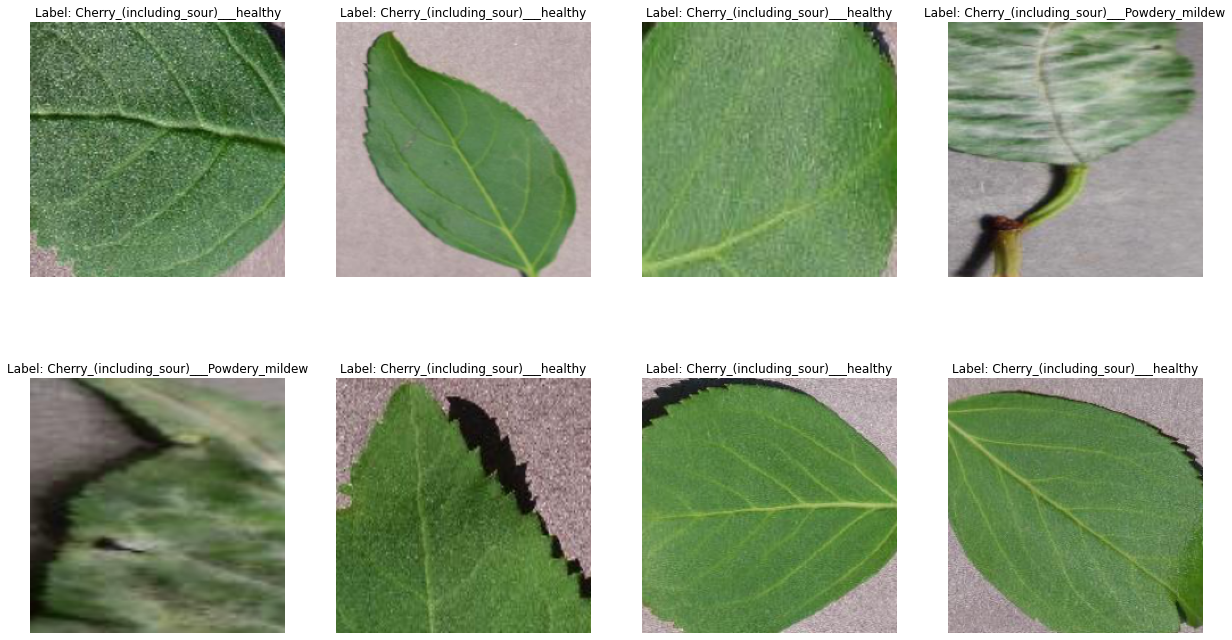

In [8]:
def showimages(imgs,actual_lbls,pred_lbls=None):
  
  fig = plt.figure(figsize=(21,12))

  for i,img in enumerate(imgs):
    
    fig.add_subplot(2, 4, i+1)
    y=actual_lbls[i]
    
    if pred_lbls!=None:
      y_pre=pred_lbls[i]
      title="prediction: {0}\nlabel:{1}".format(dataset.classes[y],dataset.classes[y_pre])
    else: 
      title="Label: {0}".format(dataset.classes[y])

    plt.title(title)
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.axis("off")
    plt.imshow(img)
  
plt.show()

inputs, classes = next(iter(train_loader))

showimages(inputs,classes)

In [9]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  accuracies['train'].append(accuracy)
  losses['train'].append(loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [10]:
def test(model,loss_fn,dataloader,epoch):
  model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 


In [11]:
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, len(dataset.classes))

model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=20
for epoch in range(1,epochs+1): 
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)


Epoch : 1


100%|██████████| 153/153 [00:10<00:00, 15.28it/s]


Train Loss: 0.166 | Accuracy: 94.819


100%|██████████| 39/39 [00:00<00:00, 40.44it/s]


Test Loss: 0.058 | Accuracy: 99.263

Epoch : 2


100%|██████████| 153/153 [00:03<00:00, 38.53it/s]


Train Loss: 0.062 | Accuracy: 98.792


100%|██████████| 39/39 [00:00<00:00, 45.80it/s]


Test Loss: 0.040 | Accuracy: 99.509

Epoch : 3


100%|██████████| 153/153 [00:04<00:00, 37.03it/s]


Train Loss: 0.047 | Accuracy: 98.956


100%|██████████| 39/39 [00:00<00:00, 45.67it/s]


Test Loss: 0.032 | Accuracy: 99.345

Epoch : 4


100%|██████████| 153/153 [00:03<00:00, 38.32it/s]


Train Loss: 0.040 | Accuracy: 99.058


100%|██████████| 39/39 [00:01<00:00, 37.92it/s]


Test Loss: 0.028 | Accuracy: 99.427

Epoch : 5


100%|██████████| 153/153 [00:04<00:00, 37.82it/s]


Train Loss: 0.034 | Accuracy: 99.345


100%|██████████| 39/39 [00:01<00:00, 38.70it/s]


Test Loss: 0.029 | Accuracy: 99.345

Epoch : 6


100%|██████████| 153/153 [00:03<00:00, 38.44it/s]


Train Loss: 0.033 | Accuracy: 99.222


100%|██████████| 39/39 [00:00<00:00, 40.33it/s]


Test Loss: 0.023 | Accuracy: 99.590

Epoch : 7


100%|██████████| 153/153 [00:04<00:00, 36.04it/s]


Train Loss: 0.027 | Accuracy: 99.447


100%|██████████| 39/39 [00:00<00:00, 45.06it/s]


Test Loss: 0.022 | Accuracy: 99.672

Epoch : 8


100%|██████████| 153/153 [00:03<00:00, 38.55it/s]


Train Loss: 0.029 | Accuracy: 99.160


100%|██████████| 39/39 [00:00<00:00, 39.65it/s]


Test Loss: 0.021 | Accuracy: 99.672

Epoch : 9


100%|██████████| 153/153 [00:03<00:00, 39.34it/s]


Train Loss: 0.025 | Accuracy: 99.447


100%|██████████| 39/39 [00:00<00:00, 44.48it/s]


Test Loss: 0.019 | Accuracy: 99.672

Epoch : 10


100%|██████████| 153/153 [00:03<00:00, 38.84it/s]


Train Loss: 0.024 | Accuracy: 99.488


100%|██████████| 39/39 [00:01<00:00, 38.75it/s]


Test Loss: 0.019 | Accuracy: 99.590

Epoch : 11


100%|██████████| 153/153 [00:03<00:00, 38.75it/s]


Train Loss: 0.025 | Accuracy: 99.406


100%|██████████| 39/39 [00:01<00:00, 38.28it/s]


Test Loss: 0.018 | Accuracy: 99.754

Epoch : 12


100%|██████████| 153/153 [00:03<00:00, 38.74it/s]


Train Loss: 0.023 | Accuracy: 99.406


100%|██████████| 39/39 [00:00<00:00, 39.89it/s]


Test Loss: 0.017 | Accuracy: 99.672

Epoch : 13


100%|██████████| 153/153 [00:03<00:00, 43.29it/s]


Train Loss: 0.021 | Accuracy: 99.529


100%|██████████| 39/39 [00:00<00:00, 41.26it/s]


Test Loss: 0.017 | Accuracy: 99.672

Epoch : 14


100%|██████████| 153/153 [00:03<00:00, 42.21it/s]


Train Loss: 0.021 | Accuracy: 99.508


100%|██████████| 39/39 [00:01<00:00, 38.47it/s]


Test Loss: 0.017 | Accuracy: 99.672

Epoch : 15


100%|██████████| 153/153 [00:03<00:00, 43.33it/s]


Train Loss: 0.021 | Accuracy: 99.468


100%|██████████| 39/39 [00:00<00:00, 46.02it/s]


Test Loss: 0.016 | Accuracy: 99.590

Epoch : 16


100%|██████████| 153/153 [00:04<00:00, 38.07it/s]


Train Loss: 0.020 | Accuracy: 99.529


100%|██████████| 39/39 [00:01<00:00, 37.89it/s]


Test Loss: 0.018 | Accuracy: 99.672

Epoch : 17


100%|██████████| 153/153 [00:04<00:00, 38.21it/s]


Train Loss: 0.022 | Accuracy: 99.406


100%|██████████| 39/39 [00:00<00:00, 40.96it/s]


Test Loss: 0.016 | Accuracy: 99.672

Epoch : 18


100%|██████████| 153/153 [00:04<00:00, 37.95it/s]


Train Loss: 0.018 | Accuracy: 99.652


100%|██████████| 39/39 [00:00<00:00, 39.88it/s]


Test Loss: 0.015 | Accuracy: 99.672

Epoch : 19


100%|██████████| 153/153 [00:04<00:00, 37.65it/s]


Train Loss: 0.019 | Accuracy: 99.488


100%|██████████| 39/39 [00:00<00:00, 39.27it/s]


Test Loss: 0.015 | Accuracy: 99.672

Epoch : 20


100%|██████████| 153/153 [00:04<00:00, 37.99it/s]


Train Loss: 0.020 | Accuracy: 99.386


100%|██████████| 39/39 [00:00<00:00, 39.23it/s]

Test Loss: 0.014 | Accuracy: 99.672


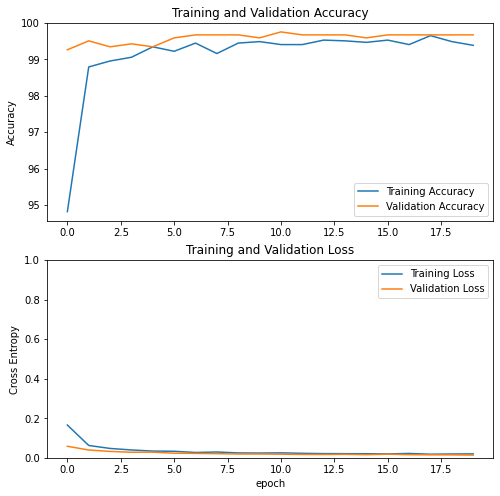

In [13]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


ValueError: num must be 1 <= num <= 8, not 9

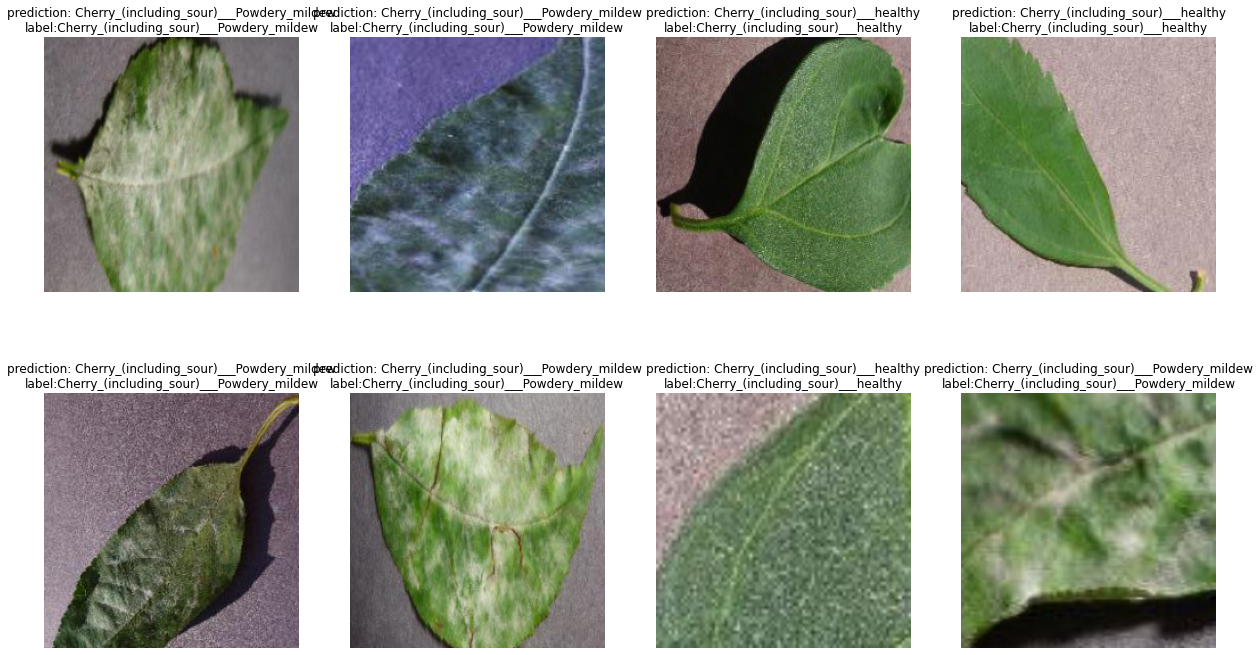

In [14]:
def predict_images(model,images,actual_label):
  model.eval()
  with torch.no_grad():
    inputs = images.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    showimages(images,actual_label,preds.cpu())

images, classes = next(iter(val_loader))

predict_images(model,images,classes)
# torch.save(model, "/kaggle/working")


In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456,0.406],
        [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])])


train_set = torchvision.datasets.ImageFolder('/kaggle/working/train', transform=train_transforms)
test_set = torchvision.datasets.ImageFolder('/kaggle/working/test', transform=test_transforms)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(train_loader)
print(test_loader)

In [ ]:
VGG_types = {
    "VGG16": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],}

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.in_channels = 3
        self.conv_layers = self.create_conv_layers(VGG_types['VGG16'])
        # self.layer1 = nn.Sequential(
        #     nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1),
        #     nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1),
        #     nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1),
        #     nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1),
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1))
        # self.layer2 = nn.AdaptiveAvgPool2d(output_size=(7,7))
        self.layer3 = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(in_features=4096, out_features=4096, bias=True),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(in_features=4096, out_features=10, bias=True),
            )

    def forward(self, x):
      x = self.conv_layers(x)
        # out = self.layer1(x)
      # out = self.layer2(x)
      out = self.layer3(out)
      return out
    def create_conv_layers(self,architecture):
      layers = []
      in_channels = self.in_channels
      for layer in architecture : 
          if type(layer) is int: 
              out_channels = layer
              layers += [nn.Conv2d(in_channels = in_channels,out_channels = out_channels, 
                                   kernel_size = (3,3), stride = (1,1), padding = (1,1)),
                                   nn.BatchNorm2d(layer),
                                   nn.ReLU()]
              in_channels = layer #for the next itteration
          elif layer == 'M': 
              layers += [nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))]
      return nn.Sequential(*layers,  )

model_ft = NeuralNetwork()


model_ft = model_ft.cuda()

import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(model_ft.parameters(), lr=0.001)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

In [ ]:
# 2. Create the neural network layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1))
        self.layer2 = nn.AdaptiveAvgPool2d(output_size=(4096))
        self.layer3 = nn.Sequential(
                nn.Linear(in_features=57344, out_features=4096, bias=True),
                nn.ReLU(),
                nn.Dropout(p=0.5),
                nn.Linear(in_features=4096, out_features=10, bias=True),
            )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out


model = NeuralNetwork()

# define the optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    
def train_model(train_loader, model):
    # enumerate epochs
    for epoch in range(10):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_loader):
#             print(inputs, targets)
            # clear the gradients
            optimizer.zero_grad()
#             # compute the model output
            yhat = model(inputs)
#             # calculate loss
            loss = criterion(yhat, targets)
#             # credit assignment
            loss.backward()
#             # update model weights
            optimizer.step()
 
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_loader):
#         # evaluate the model on the test set
#         print(input)
        yhat = model(inputs)
#         # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
#         # round to class values
        yhat = yhat.round()
#         # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
#     # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    correct += (yhat == labels).float().sum()
    acc = 100 * correct / len(trainset)
    print(predictions, actuals)
    return acc
 
# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

In [ ]:
train_model(train_loader, model)
# evaluate the model
acc = evaluate_model(test_loader, model)
print('Accuracy: %.3f' % acc)